<a href="https://colab.research.google.com/github/bc0403/acoustics/blob/main/20221106_lgs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Purpose
分析LGS不同切向的声表面波模式

In [ ]:
# Created by Hao Jin on 2022/11/06
import numpy as np
from sympy import (symbols, Matrix, Rational, eye, solve, init_printing, 
                   lambdify, diff, simplify, re, im, solveset, zeros, ones,
                   pprint)
init_printing(use_unicode=True)
from numpy import linalg as LA
import time
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# define material properties for Trigonal32
c11, c12, c13, c14, c33, c44 = symbols('c11, c12, c13, c14, c33, c44')
e_x1, e_x4 = symbols('e_x1, e_x4')
epsilon_xx, epsilon_zz = symbols('epsilon_xx, epsilon_zz')

cE_32 = Matrix([
    [c11, c12, c13, c14, 0, 0],
    [c12, c11, c13, -c14, 0, 0],
    [c13, c13, c33, 0, 0, 0],
    [c14, -c14, 0, c44, 0, 0],
    [0, 0, 0, 0, c44, c14],
    [0, 0, 0, 0, c14, Rational(1,2)*(c11 - c12)]
]) 

e_32 = Matrix([
    [e_x1, -e_x1, 0, e_x4, 0, 0],
    [0, 0, 0, 0, -e_x4, -e_x1],
    [0, 0, 0, 0, 0, 0]
])

epsilonS_32 = Matrix([
    [epsilon_xx, 0, 0],
    [0, epsilon_xx, 0],
    [0, 0, epsilon_zz]
])

cE_32

⎡c₁₁  c₁₂   c₁₃  c₁₄    0       0    ⎤
⎢                                    ⎥
⎢c₁₂  c₁₁   c₁₃  -c₁₄   0       0    ⎥
⎢                                    ⎥
⎢c₁₃  c₁₃   c₃₃   0     0       0    ⎥
⎢                                    ⎥
⎢c₁₄  -c₁₄   0   c₄₄    0       0    ⎥
⎢                                    ⎥
⎢ 0    0     0    0    c₄₄     c₁₄   ⎥
⎢                                    ⎥
⎢                           c₁₁   c₁₂⎥
⎢ 0    0     0    0    c₁₄  ─── - ───⎥
⎣                            2     2 ⎦

In [ ]:
e_32

⎡eₓ₁  -eₓ₁  0  eₓ₄   0     0  ⎤
⎢                             ⎥
⎢ 0    0    0   0   -eₓ₄  -eₓ₁⎥
⎢                             ⎥
⎣ 0    0    0   0    0     0  ⎦

In [ ]:
epsilonS_32

⎡εₓₓ   0    0  ⎤
⎢              ⎥
⎢ 0   εₓₓ   0  ⎥
⎢              ⎥
⎣ 0    0   ε_zz⎦

In [ ]:
# material properties of LGS, from (ggzhang2022)
rho = 5739  # kg/m^3
c0 = cE_32.evalf(subs={c11:18.89, c12:10.41, c13:10.15, c14:1.442, c33:26.83, 
                      c44: 5.33})*1e10  # Pa
e0 = e_32.evalf(subs={e_x1:-0.437, e_x4:0.104})  # C/m^2
epsilonS0 = epsilonS_32.evalf(subs={epsilon_xx:16.87, 
                                  epsilon_zz:45.87})*1e-11  # F/m

c0

⎡188900000000.0  104100000000.0  101500000000.0  14420000000.0         0      
⎢                                                                             
⎢104100000000.0  188900000000.0  101500000000.0  -14420000000.0        0      
⎢                                                                             
⎢101500000000.0  101500000000.0  268300000000.0        0               0      
⎢                                                                             
⎢14420000000.0   -14420000000.0        0         53300000000.0         0      
⎢                                                                             
⎢      0               0               0               0         53300000000.0
⎢                                                                             
⎣      0               0               0               0         14420000000.0

        0      ⎤
               ⎥
        0      ⎥
               ⎥
        0      ⎥
               ⎥
        0      ⎥
           

In [ ]:
e0

⎡-0.437  0.437  0  0.104    0       0  ⎤
⎢                                      ⎥
⎢  0       0    0    0    -0.104  0.437⎥
⎢                                      ⎥
⎣  0       0    0    0      0       0  ⎦

In [ ]:
epsilonS0

⎡1.687e-10      0          0    ⎤
⎢                               ⎥
⎢    0      1.687e-10      0    ⎥
⎢                               ⎥
⎣    0          0      4.587e-10⎦

In [ ]:
# define Euler angles
def rot_by_z(angle):
    """
    rotate of angle about the z-axis
    return the rotational matrix

    input: 
    - anlge, in deg
    output: 
    - 3x3 matrix
    """
    angle_rad = angle/180*np.pi
    return np.array([
        [np.cos(angle_rad), np.sin(angle_rad), 0],
        [-np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])

def rot_by_x(angle):
    """
    rotate of angle about the x-axis
    return the rotational matrix

    input: 
    - anlge, in deg
    output: 
    - 3x3 matrix
    """
    angle_rad = angle/180*np.pi
    return np.array([
        [1, 0, 0],
        [0, np.cos(angle_rad), np.sin(angle_rad)],
        [0, -np.sin(angle_rad), np.cos(angle_rad)]
    ])

def rot_a(phi, theta, psi):
    """
    rotation matrix a for Euler angles

    input: 
    - Euler angles, in deg
    output: 
    - 3x3 matrix
    """
    return np.matmul(np.matmul(rot_by_z(psi), rot_by_x(theta)), rot_by_z(phi))

def rot_a_M(phi, theta, psi):
    """
    rotation matrix a and M for Euler angles

    input: 
    - Euler angles, in deg
    output: 
    - (a, M), a in 3x3, M in 6x6
    """
    R = rot_a(phi, theta, psi)
    R00 = R[0, 0]
    R01 = R[0, 1]
    R02 = R[0, 2]
    R10 = R[1, 0]
    R11 = R[1, 1]
    R12 = R[1, 2]
    R20 = R[2, 0]
    R21 = R[2, 1]
    R22 = R[2, 2]

    M = np.array([
        [R00**2, R01**2, R02**2, 2*R01*R02, 2*R02*R00, 2*R00*R01],
        [R10**2, R11**2, R12**2, 2*R11*R12, 2*R12*R10, 2*R10*R11],
        [R20**2, R21**2, R22**2, 2*R21*R22, 2*R22*R20, 2*R20*R21],
        [R10*R20, R11*R21, R12*R22, R11*R22 + R12*R21, R10*R22 + R12*R20,
            R10*R21 + R11*R20],
        [R20*R00, R21*R01, R22*R02, R01*R22 + R02*R21, R00*R22 + R02*R20,
            R00*R21 + R01*R20],
        [R00*R10, R01*R11, R02*R12, R01*R12 + R02*R11, R00*R12 + R02*R10,
            R00*R11 + R01*R10]
    ])
    return (R, M)

def rot_material_properties(phi, theta, psi, c, e, epsilonS):
    """
    updated material properties after Euler rotation

    input: 
    - phi, Euler angle, in deg;
    - theta, Euler angle, in deg;
    - psi, Euler angle, in deg; 
    - c, stiffness, 6x6, in GPa;
    - e, piezoelectric stress constant, 3x6, in C/m^2;
    - epsilonS, permittivity, 3x3, in F/m;
    output:
    - c', updated stiffness;
    - e', updated piezoelectric stress constant;
    - epsilonS', updated permittivity.
    """
    R, M = rot_a_M(phi, theta, psi)
    c1 = np.matmul(np.matmul(M, c), M.T)
    e1 = np.matmul(np.matmul(R, e), M.T)
    epsilonS1 = np.matmul(np.matmul(R, epsilonS), R.T)
    return (c1, e1, epsilonS1)

In [ ]:
# define characteristic matrix
b, v = symbols('b, v')  # attenuation constant, velocity
Nab = Matrix([
    [1, 0, 0, 0, b, 0],
    [0, 0, 0, b, 0, 1],
    [0, 0, b, 0, 1, 0]
])

# SymPy being slow to generate a 4x4 determinant is a bug
# refer to https://stackoverflow.com/questions/37026935/speeding-up-computation-of-symbolic-determinant-in-sympy
AA = Matrix(4, 4, symbols('AA:4:4'))

# evaluate the velocity of bulk shear wave for initial guess
# wave propagates along [lx ly lz]
def evaluate_init_velocity(c, e, epsilon):
    lx = 1
    ly = 0
    lz = 0

    li = np.array([lx, ly, lz]).reshape(1, -1)
    lj = li.T
    liK = np.array([
        [lx, 0, 0, 0, lz, ly],
        [0, ly, 0, lz, 0, lx],
        [0, 0, lz, ly, lx, 0]
    ])
    lLj = liK.T

    a = np.matmul(np.matmul(li, np.array(epsilon)), lj)
    b1 = np.matmul(np.array(e).T, lj)
    b2 = np.matmul(li, np.array(e))
    b = np.matmul(b1, b2)
    c_D = c + np.multiply(b, 1/a)*1e-9
    # evaluate Gamma matrix
    Gamma0 = np.array(np.matmul(np.matmul(liK, c_D), lLj), dtype=float)
    w, v = LA.eig(Gamma0)
    va = np.sqrt(np.multiply(w, 1/rho))  # m/s
    print("\nbulk wave velocities, m/s\n", va)
    print(f"chose {np.ceil(min(va))} m/s for initial value")
    return np.ceil(min(va))

In [ ]:
def evaluate_velocity_free(psi):
    # rotated by (0, 0, psi)
    c1, e1, epsilonS1 = rot_material_properties(0, 0, psi, c0, e0, epsilonS0)
    c1 = Matrix(c1)
    e1 = Matrix(e1)
    epsilonS1 = Matrix(epsilonS1)

    # construct Characteristic Matrix A
    Gamma = Nab*c1*Nab.T.evalf()
    gamma = Nab*e1.T*Matrix([1, 0, b]).evalf()
    epsilon_4 = Matrix([1, 0, b]).T*epsilonS1*Matrix([1, 0, b]).evalf()
    A = Gamma - eye(3)*rho*v**2
    A = A.col_insert(3, gamma)
    row4 = gamma.T
    row4 = row4.col_insert(3, -epsilon_4)
    A = A.row_insert(3, row4)  # with b & v

    # using the slowest bulk shear wave for initial guess
    v_pred = evaluate_init_velocity(c1, e1, epsilonS1)

    v_free= seek_velocity_free(c1, e1, epsilonS1, A, v_pred)
    return v_free

In [ ]:
def seek_velocity_free(c1, e1, epsilonS1, A, v_pred):
    # determinant of A
    A_det = simplify(AA.det().subs(zip(list(AA), list(A))))

    v_list = [v_pred]
    v_metal_list = []
    det_free_list = [1]
    det_metal_list = [1]
    learning_rate = 1
    iters = 3
    start_time = time.time()
    for i in range(iters):    
        print(f"iteration {i}, start guess with step {learning_rate}")
        for j in range(1000): # max search steps
            if i%2 == 0:  # searching back and forth 
                v_pred -= learning_rate
                # print(v_pred)
            else:
                v_pred += learning_rate
            
            # determinant of Characteristic Matrix with guessed velocity
            A_det_polyb = A_det.subs(v, v_pred).evalf()
            
            # solve b
            blist = solveset(A_det_polyb, b)
            blist = list(blist)
            
            # choose appropriate b values
            bs = []
            for k in range(len(blist)):
                blist[k].as_real_imag()
                if im(blist[k]) < 0:
                    bs.append(blist[k])
            # print(bs)

            # calculate nullspace
            vecs = []
            for bi in bs:
                U, S, V = svd(np.array(A.subs({b:bi, v:v_pred}).evalf(),dtype=complex))
                vecs.append(Matrix(V).col(3))
            
            if len(bs) < 4:
                print(f"guess {v_pred}, number of b ({len(bs)}) is less than 4, skip")
                continue

            # judge the velocity
            alpha1, alpha2, alpha3, alpha4 = symbols('alpha1 alpha2 alpha3 alpha4')  # linear combine coeff
            u1 = Matrix([
                vecs[0].row(0),
                vecs[0].row(1),
                vecs[0].row(2)
            ])
            u2 = Matrix([
                vecs[1].row(0),
                vecs[1].row(1),
                vecs[1].row(2)
            ])
            u3 = Matrix([
                vecs[2].row(0),
                vecs[2].row(1),
                vecs[2].row(2)
            ])
            u4 = Matrix([
                vecs[3].row(0),
                vecs[3].row(1),
                vecs[3].row(2)
            ])
            T = (-c1*Nab.subs(b, bs[0]).T*u1 - e1.T*Matrix([1, 0, bs[0]])*vecs[0].row(3))*alpha1 +\
                (-c1*Nab.subs(b, bs[1]).T*u2 - e1.T*Matrix([1, 0, bs[1]])*vecs[1].row(3))*alpha2 +\
                (-c1*Nab.subs(b, bs[2]).T*u3 - e1.T*Matrix([1, 0, bs[2]])*vecs[2].row(3))*alpha3 +\
                (-c1*Nab.subs(b, bs[3]).T*u4 - e1.T*Matrix([1, 0, bs[3]])*vecs[3].row(3))*alpha4
            D = (-e1*Nab.subs(b, bs[0]).T*u1 + epsilonS1.T*Matrix([1, 0, bs[0]])*vecs[0].row(3))*alpha1 +\
                (-e1*Nab.subs(b, bs[1]).T*u2 + epsilonS1.T*Matrix([1, 0, bs[1]])*vecs[1].row(3))*alpha2 +\
                (-e1*Nab.subs(b, bs[2]).T*u3 + epsilonS1.T*Matrix([1, 0, bs[2]])*vecs[2].row(3))*alpha3 +\
                (-e1*Nab.subs(b, bs[3]).T*u4 + epsilonS1.T*Matrix([1, 0, bs[3]])*vecs[3].row(3))*alpha4
            PHI = vecs[0].row(3)*alpha1 + \
                vecs[1].row(3)*alpha2 + \
                vecs[2].row(3)*alpha3 + \
                vecs[3].row(3)*alpha4
            B_free = Matrix([
                [diff(T.row(2),alpha1), diff(T.row(2),alpha2), diff(T.row(2),alpha3), diff(T.row(2),alpha4)],
                [diff(T.row(3),alpha1), diff(T.row(3),alpha2), diff(T.row(3),alpha3), diff(T.row(3),alpha4)],
                [diff(T.row(4),alpha1), diff(T.row(4),alpha2), diff(T.row(4),alpha3), diff(T.row(4),alpha4)],
                [diff(D.row(2),alpha1), diff(D.row(2),alpha2), diff(D.row(2),alpha3), diff(D.row(2),alpha4)]
            ])
            B_metal = Matrix([
                [diff(T.row(2),alpha1), diff(T.row(2),alpha2), diff(T.row(2),alpha3), diff(T.row(2),alpha4)],
                [diff(T.row(3),alpha1), diff(T.row(3),alpha2), diff(T.row(3),alpha3), diff(T.row(3),alpha4)],
                [diff(T.row(4),alpha1), diff(T.row(4),alpha2), diff(T.row(4),alpha3), diff(T.row(4),alpha4)],
                [diff(PHI,alpha1), diff(PHI,alpha2), diff(PHI,alpha3), diff(PHI,alpha4)]
            ])
            # loss fuction
            loss1 = abs(B_free.det())
            loss2 = abs(B_metal.det())
            det_free_list.append(loss1)
            det_metal_list.append(loss2)
            v_list.append(v_pred)
            print(f"guess {v_pred}: det of B_free and B_metal are: {loss1}, {loss2}")
            if abs(det_free_list[-1])>abs(det_free_list[-2]):
                learning_rate *= 0.1
                break

    end_time = time.time()
    print("======")
    print(f"the free velocity is {v_list[-2]:.2f} m/s")  # iters-1 
    print(f"time escaped: {end_time-start_time:.3f} s")
    return v_list[-2]


流式输出内容被截断，只能显示最后 5000 行内容。
guess 2703.0, number of b (3) is less than 4, skip
guess 2702.0, number of b (3) is less than 4, skip
guess 2701.0, number of b (3) is less than 4, skip
guess 2700.0, number of b (3) is less than 4, skip
guess 2699.0, number of b (3) is less than 4, skip
guess 2698.0, number of b (3) is less than 4, skip
guess 2697.0, number of b (3) is less than 4, skip
guess 2696.0, number of b (3) is less than 4, skip
guess 2695.0, number of b (3) is less than 4, skip
guess 2694.0, number of b (3) is less than 4, skip
guess 2693.0, number of b (3) is less than 4, skip
guess 2692.0, number of b (3) is less than 4, skip
guess 2691.0, number of b (3) is less than 4, skip
guess 2690.0, number of b (3) is less than 4, skip
guess 2689.0, number of b (3) is less than 4, skip
guess 2688.0, number of b (3) is less than 4, skip
guess 2687.0, number of b (3) is less than 4, skip
guess 2686.0, number of b (3) is less than 4, skip
guess 2685.0, number of b (3) is less than 4, skip
gues

NameError: ignored

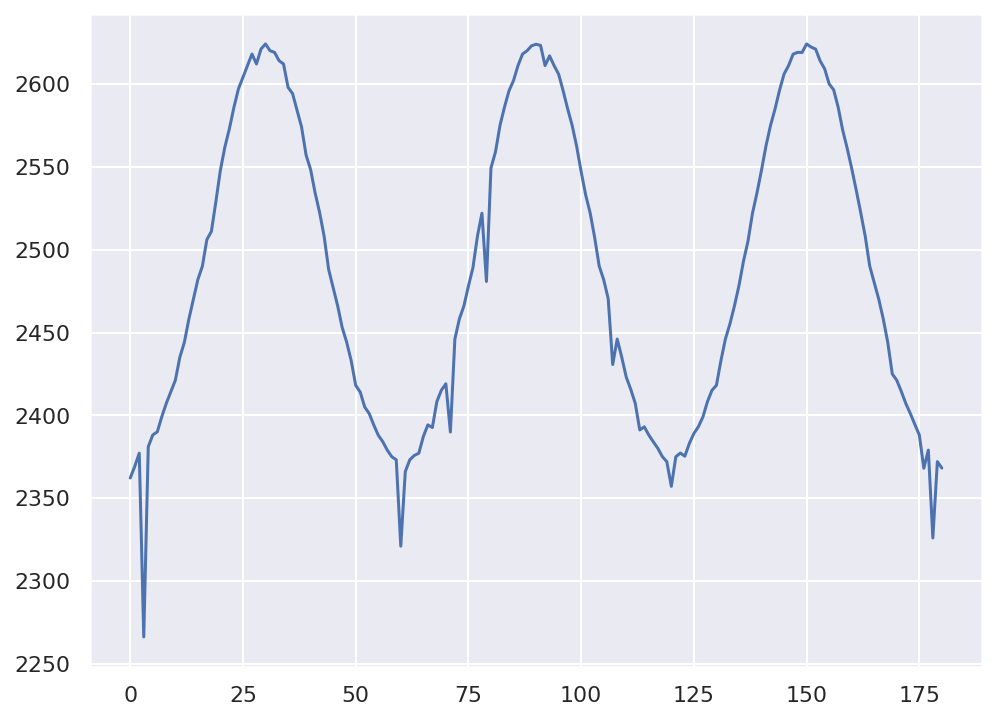

In [ ]:
psi = np.linspace(0, 180, 181)
v_free_psi = np.zeros(len(psi))

for i in range(len(psi)):
    print(f"\npsi: {psi[i]} deg")
    v_free_psi[i] = evaluate_velocity_free(psi[i])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(psi, v_free_psi)
ax.plot(psi, v_metal_psi)
